## Stock Research Example

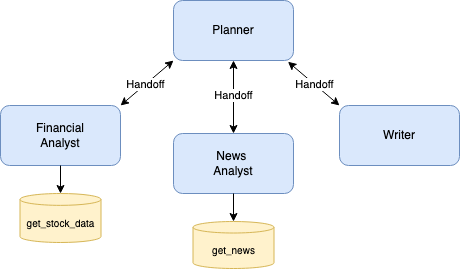

### This system is designed to perform stock research tasks by leveraging four agents:

- Planner: The central coordinator that delegates specific tasks to specialized agents based on their expertise. The planner ensures that each agent is utilized efficiently and oversees the overall workflow.

- Financial Analyst: A specialized agent responsible for analyzing financial metrics and stock data using tools such as get_stock_data.

- News Analyst: An agent focused on gathering and summarizing recent news articles relevant to the stock, using tools such as get_news.

- Writer: An agent tasked with compiling the findings from the stock and news analysis into a cohesive final report.

## Workflow
1. The Planner initiates the research process by delegating tasks to the appropriate agents in a step-by-step manner.

2. Each agent performs its task independently and appends their work to the shared message thread/history. Rather than directly returning results to the planner, all agents contribute to and read from this shared message history. When agents generate their work using the LLM, they have access to this shared message history, which provides context and helps track the overall progress of the task.

3. Once an agent completes its task, it hands off control back to the planner.

4. The process continues until the planner determines that all necessary tasks have been completed and decides to terminate the workflow.

## Load dependencies

In [ ]:
from typing import Any, Dict, List

from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import HandoffTermination, TextMentionTermination
from autogen_agentchat.messages import HandoffMessage
from autogen_agentchat.teams import Swarm
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient


## Let's define some tools first

In [ ]:
async def get_stock_data(symbol: str) -> Dict[str, Any]:
    """Get stock market data for a given symbol"""
    return {"price": 180.25, "volume": 1000000, "pe_ratio": 65.4, "market_cap": "700B"}


async def get_news(query: str) -> List[Dict[str, str]]:
    """Get recent news articles about a company"""
    return [
        {
            "title": "Tesla Expands Cybertruck Production",
            "date": "2024-03-20",
            "summary": "Tesla ramps up Cybertruck manufacturing capacity at Gigafactory Texas, aiming to meet strong demand.",
        },
        {
            "title": "Tesla FSD Beta Shows Promise",
            "date": "2024-03-19",
            "summary": "Latest Full Self-Driving beta demonstrates significant improvements in urban navigation and safety features.",
        },
        {
            "title": "Model Y Dominates Global EV Sales",
            "date": "2024-03-18",
            "summary": "Tesla's Model Y becomes best-selling electric vehicle worldwide, capturing significant market share.",
        },
    ]


In [12]:
model_client = AzureOpenAIChatCompletionClient(
    azure_deployment="gpt-4o",
    azure_endpoint="https://aq-aoai-swedencentral.openai.azure.com/",
    model="gpt-4o",
    api_version="2025-03-01-preview",
    api_key="3ShjYyRHd6t0VthIuoOUe1GEnwlj1tkNSHkOs6IrO1CxKQ3gHmsIJQQJ99BAACfhMk5XJ3w3AAABACOG3ddZ",
    temperature=0.7,
)

In [13]:
planner = AssistantAgent(
    "planner",
    model_client=model_client,
    handoffs=["financial_analyst", "news_analyst", "writer"],
    
    system_message="""
    You are a research planning coordinator.
    Coordinate market research by delegating to specialized agents:
    - Financial Analyst: For stock data analysis
    - News Analyst: For news gathering and analysis
    - Writer: For compiling final report
    Always send your plan first, then handoff to appropriate agent.
    Always handoff to a single agent at a time.
    Use TERMINATE when research is complete.
    """,
)

financial_analyst = AssistantAgent(
    "financial_analyst",
    model_client=model_client,
    handoffs=["planner"],
    tools=[get_stock_data],
    system_message="""
    You are a financial analyst.
    Analyze stock market data using the get_stock_data tool.
    Provide insights on financial metrics.
    Always handoff back to planner when analysis is complete.
    """,
)

news_analyst = AssistantAgent(
    "news_analyst",
    model_client=model_client,
    handoffs=["planner"],
    tools=[get_news],
    system_message="""
    You are a news analyst.
    Gather and analyze relevant news using the get_news tool.
    Summarize key market insights from news.
    Always handoff back to planner when analysis is complete.
    """,
)

writer = AssistantAgent(
    "writer",
    model_client=model_client,
    handoffs=["planner"],
    system_message="""
    You are a financial report writer.
    Compile research findings into clear, concise reports.
    Always handoff back to planner when writing is complete.
    """,
)


In [ ]:
# Define termination condition
text_termination = TextMentionTermination("TERMINATE")
termination = text_termination

research_team = Swarm(
    participants=[planner, financial_analyst, news_analyst, writer], termination_condition=termination
)

task = "Conduct market research for TSLA stock"
await Console(research_team.run_stream(task=task))
await model_client.close()


---------- user ----------
Conduct market research for TSLA stock
Conduct market research for TSLA stock
---------- planner ----------
### Research Plan for TSLA Stock

1. **Financial Analysis**: Delegate to the financial analyst to gather and analyze stock data for TSLA. This will include historical performance, current trends, volatility, and key financial metrics.

2. **News Analysis**: Delegate to the news analyst to collect relevant news articles, press releases, and media coverage about TSLA. Focus on factors influencing the stock price, including company updates, market sentiment, and external factors.

3. **Report Compilation**: Delegate to the writer to compile findings from both the financial and news analyses into a cohesive market research report.

I will begin by delegating to the financial analyst first.
---------- planner ----------
[FunctionCall(id='call_4HDjGdeCHDxyX4ErjGZz7O0D', arguments='{}', name='transfer_to_financial_analyst')]
---------- planner ----------
[Func